# Introduction

In recent years, the application of computer vision in agriculture has gained significant traction due to its potential to revolutionize farming practices. One critical area where computer vision can make a substantial impact is in the classification of fruits and vegetables based on their health status. This project aims to develop a robust computer vision model using Keras, KerasCV, and TensorFlow to classify images of fruits and vegetables as either healthy or rotten.

The classification of fruits and vegetables is crucial for various stakeholders in the agricultural supply chain, including farmers, retailers, and consumers. For farmers, early detection of rotten produce can help in reducing waste and optimizing harvesting practices. For retailers, accurate classification can enhance inventory management and ensure that only high-quality products reach the shelves. For consumers, it provides assurance of the quality and safety of the produce they purchase.

# Problem Statement
The primary objective of this project is to develop an efficient and accurate image classification model that can differentiate between rotten and healthy fruits and vegetables. The ability to automatically detect and classify the condition of produce is crucial for several reasons:
1. **Quality Control**: Ensuring that only high-quality, healthy produce reaches the market, thereby maintaining consumer trust and satisfaction.
2. **Resource Optimization**: Reducing waste by identifying and removing rotten produce early in the supply chain, which can lead to significant cost savings.
3. **Food Safety**: Preventing the distribution of rotten produce, which can pose health risks to consumers.

To achieve this, we will employ a dataset of approximately 30,000 images, covering a wide range of fruits and vegetables in both healthy and rotten states. The project will involve the following key steps:
1. **Image Preprocessing**: Enhancing the quality and consistency of the input images to improve model performance.
2. **Image Augmentation**: Expanding the dataset by applying various transformations to the images, which helps in improving the model's generalization capabilities.
3. **Model Fine-Tuning**: Utilizing the EfficientNetV2B3 architecture, a state-of-the-art convolutional neural network, and fine-tuning it on our specific dataset to achieve high accuracy in classification.

In [1]:
!nvidia-smi

Sun Sep  8 17:32:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import shutil
import keras
import random
import keras_cv
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import image_dataset_from_directory
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

2024-09-08 17:32:41.889218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 17:32:41.889367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 17:32:42.016462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Reproducability
tf.keras.utils.set_random_seed(101)

# Exploring the working directory

In [5]:
def get_sub_dirs(directory):
    sub_dirs = []
    for root, _, _, in os.walk(directory):
        if root.split('/')[-1].split('__')[-1] in ['Rotten', 'Healthy']:
            sub_dirs.append(root)
    sub_dirs.sort()
    return sub_dirs

In [6]:
# Creating a list of all sub-directories pertaining to image categories in /kaggle/input/
sub_dirs = get_sub_dirs('/kaggle/input/')
sub_dirs[:5]

['/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset/Apple__Healthy',
 '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset/Apple__Rotten',
 '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset/Banana__Healthy',
 '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset/Banana__Rotten',
 '/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset/Bellpepper__Healthy']

In [7]:
# Getting the total number of images
total_images = 0
for path in sub_dirs:
    total_images += len(os.listdir(path))
total_images

29291

In [8]:
# Defining the directory paths
train_dir = '/kaggle/working/training-images/'
valid_dir = '/kaggle/working/validation-images/'
test_dir = '/kaggle/working/test-images/'

In [9]:
# Creating the sub directories
for x in sub_dirs:
    os.makedirs(train_dir + x.split('/')[-1], exist_ok=True)
    os.makedirs(valid_dir + x.split('/')[-1], exist_ok=True)
    os.makedirs(test_dir + x.split('/')[-1], exist_ok=True)

# Exploratory Data Analysis

* Let's create a dataframe for all types of fruits and vegetables images

In [10]:
fruits_and_veggies = []
num_total = []
num_rotten = []
num_healthy = []


for path in sub_dirs:
    x = path.split('/')[-1].split('__')[0]
    if x not in fruits_and_veggies:
        fruits_and_veggies.append(x)


for x in fruits_and_veggies:
    num = 0
    rotten = 0
    healthy = 0
    for dirs in sub_dirs:
        if x in dirs:
            num += len(os.listdir(dirs))
        if f"{x}__Rotten" in dirs:
            rotten += len(os.listdir(dirs))
        if f"{x}__Healthy" in dirs:
            healthy += len(os.listdir(dirs))
    num_total.append(num)
    num_rotten.append(rotten)
    num_healthy.append(healthy)


fruits_and_veggies_dict = {"fruits" : fruits_and_veggies, "total" : num_total, "rotten" : num_rotten, "healthy": num_healthy}
fruits_and_veggies_df = pd.DataFrame.from_dict(fruits_and_veggies_dict).sort_values(by=['total'])

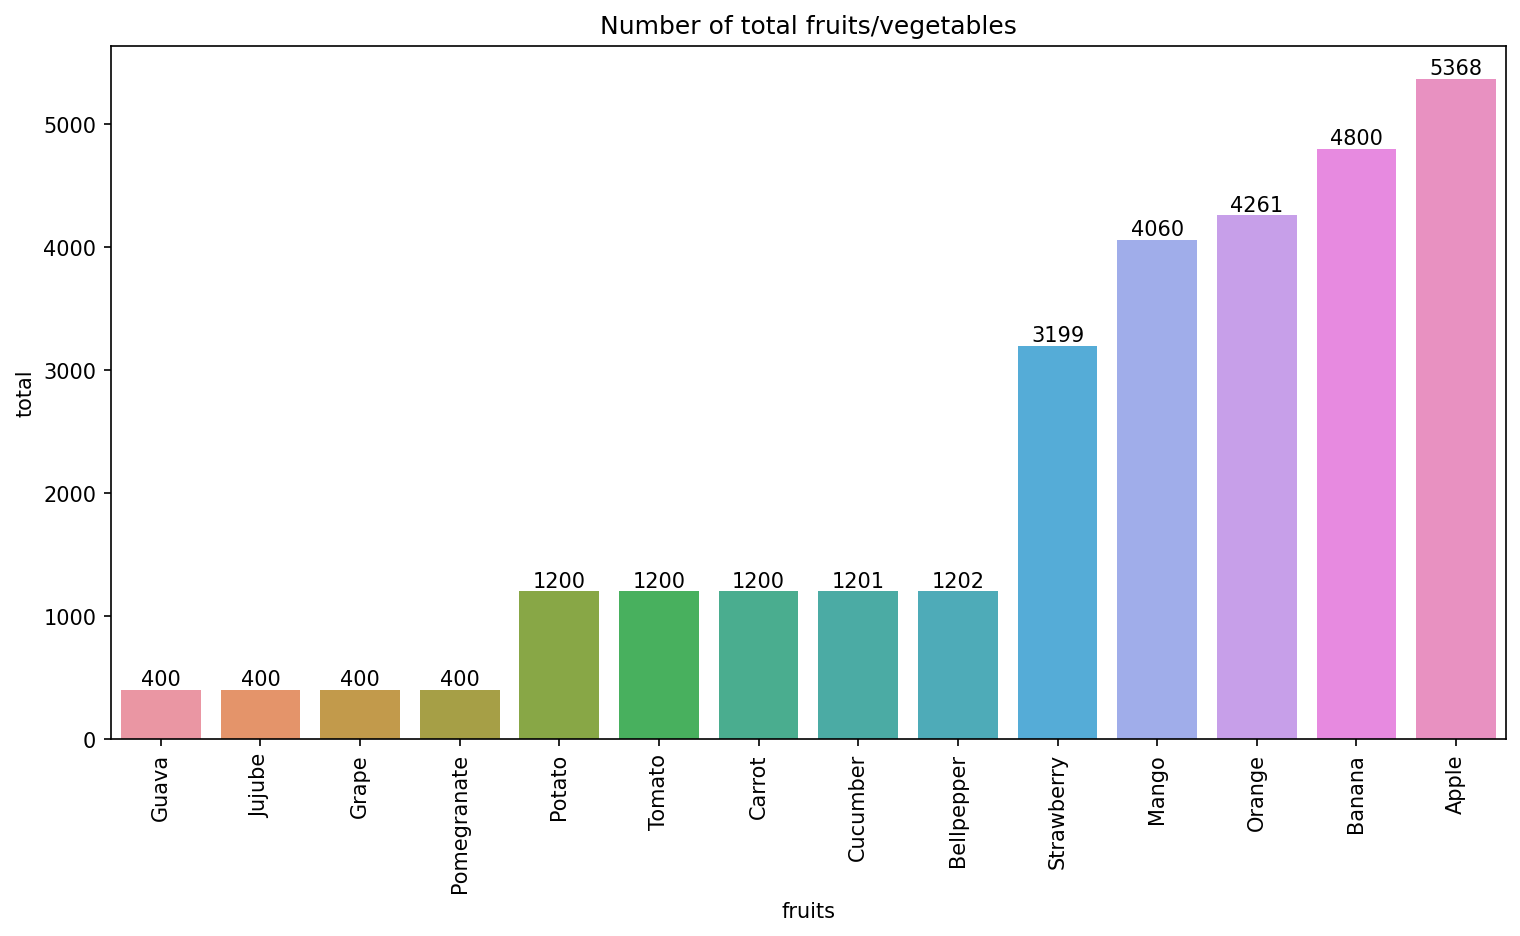

In [11]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of total fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='total')
ax.bar_label(ax.containers[0], fontsize=10);

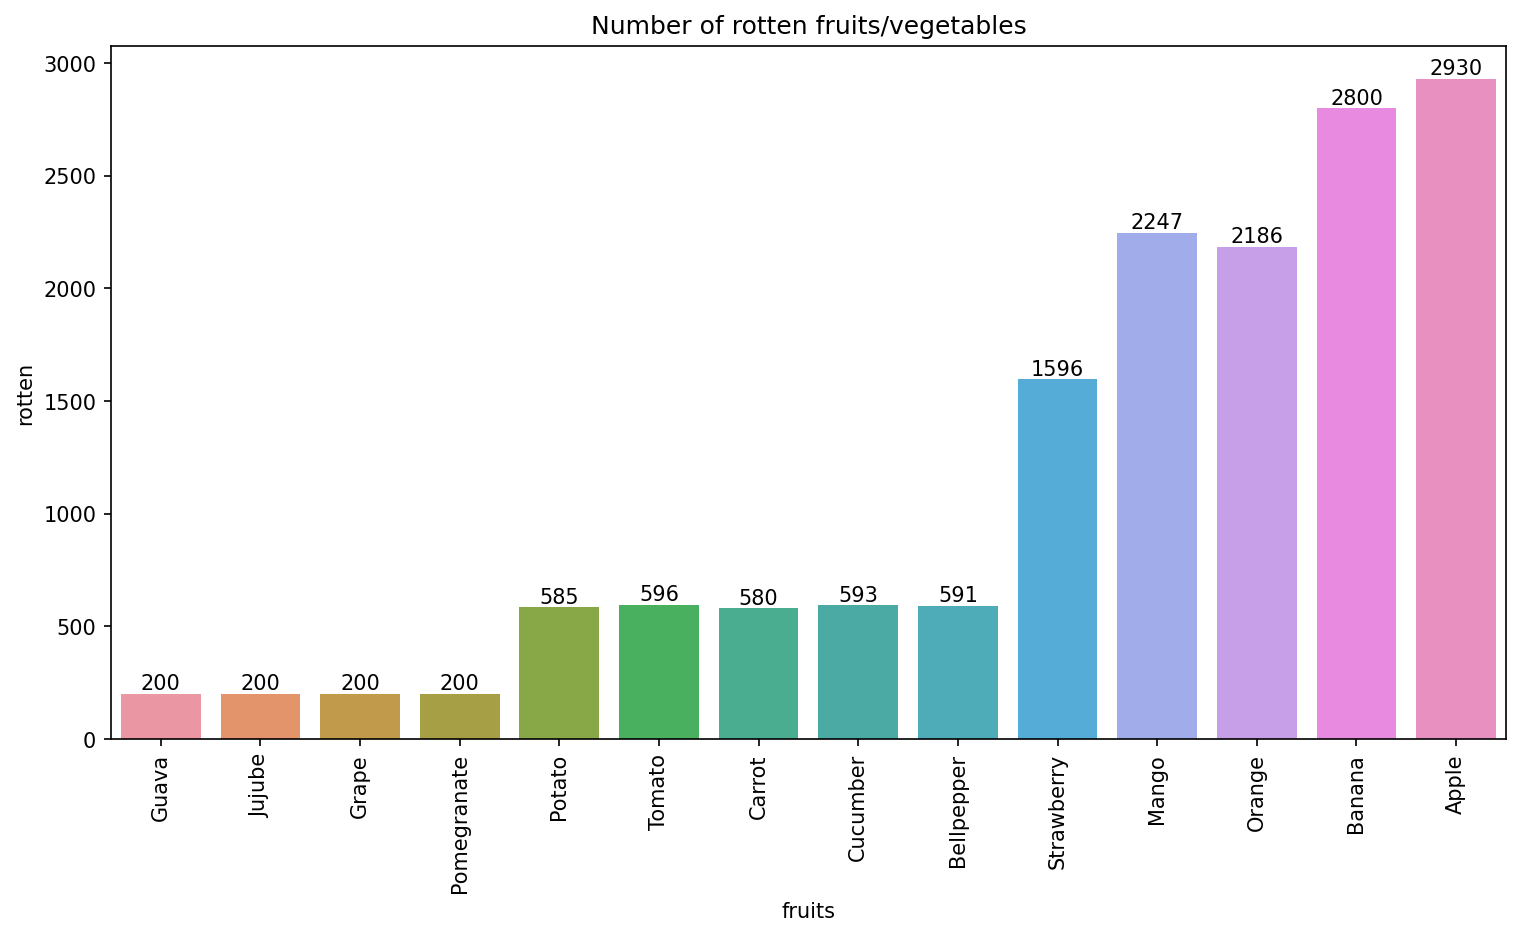

In [12]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of rotten fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='rotten')
ax.bar_label(ax.containers[0], fontsize=10);

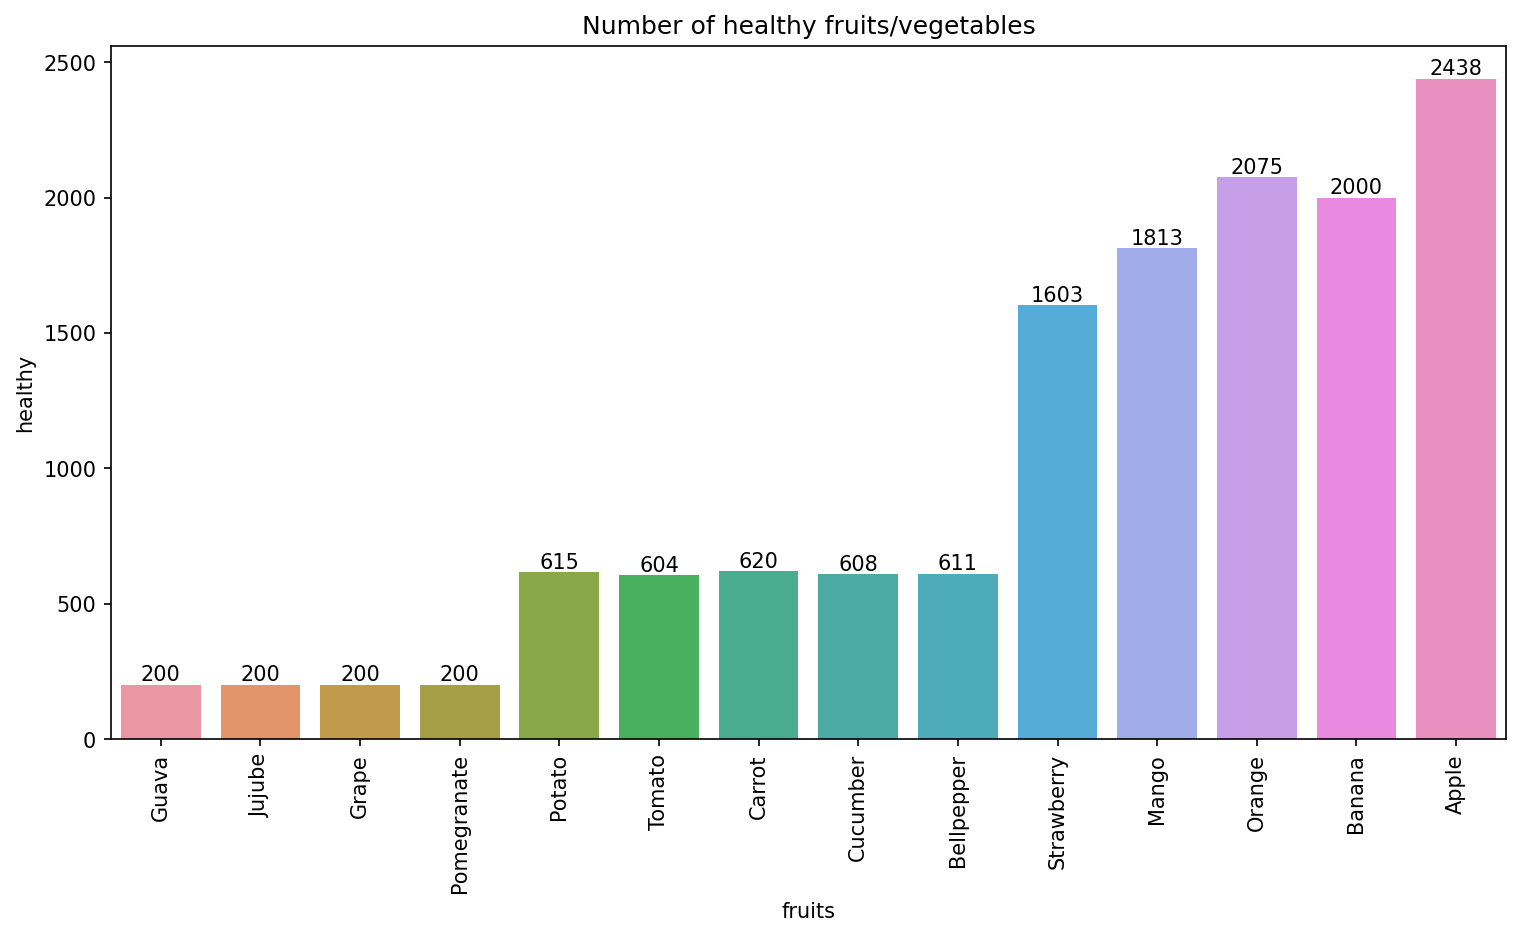

In [13]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of healthy fruits/vegetables")
plt.xticks(rotation=90)
ax = sns.barplot(fruits_and_veggies_df, x='fruits', y='healthy')
ax.bar_label(ax.containers[0], fontsize=10);

In [14]:
# Function for plotting 2 random images from a folder
def plot_random_images_from_directory(directory_path):
    all_files = os.listdir(directory_path) 
    if len(all_files) < 4:
        print("Not enough images in the directory to display.")
        return
    selected_images = random.sample(all_files, 2)
    fig, axes = plt.subplots(1, 2, figsize=(4, 4), dpi=100)
    for i, ax in enumerate(axes.flat):
        image_path = os.path.join(directory_path, selected_images[i])
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    class_name = os.path.basename(directory_path)
    fig.suptitle(class_name, fontsize=16)
    plt.tight_layout()
    plt.show()

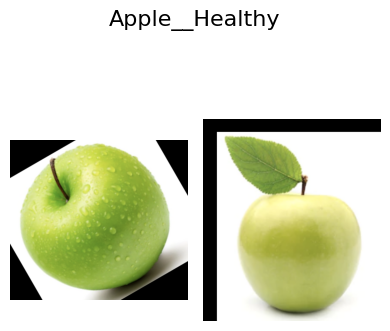

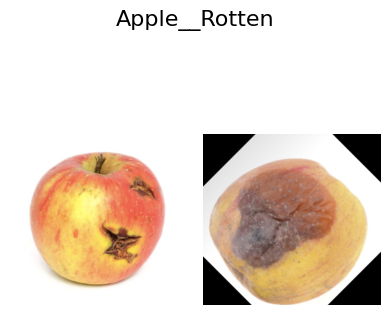

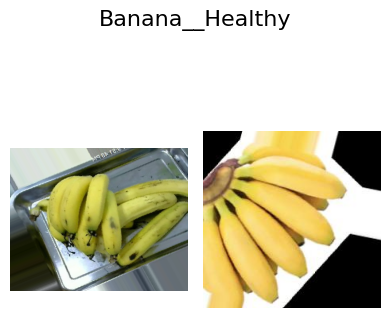

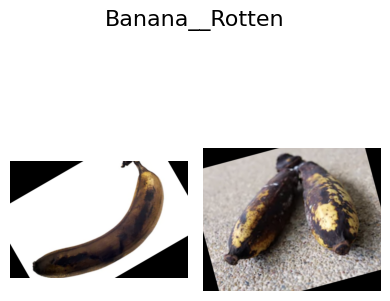

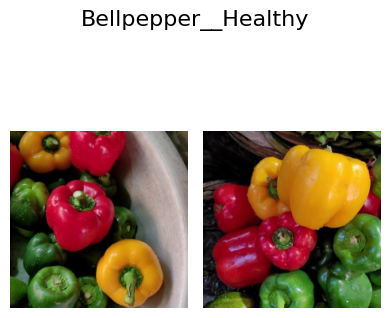

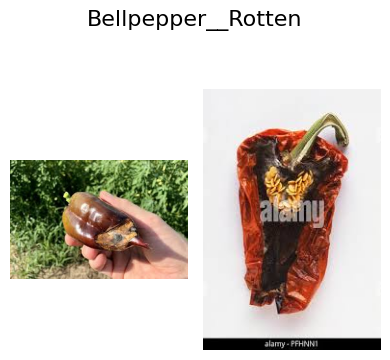

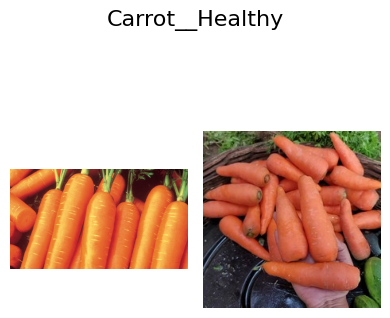

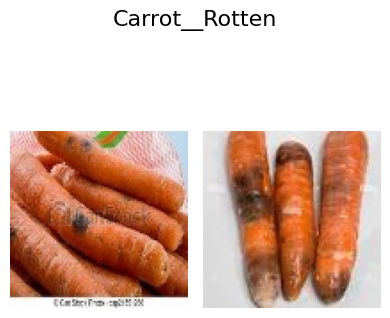

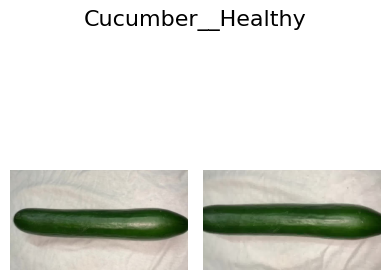

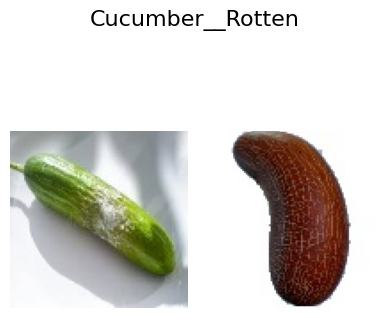

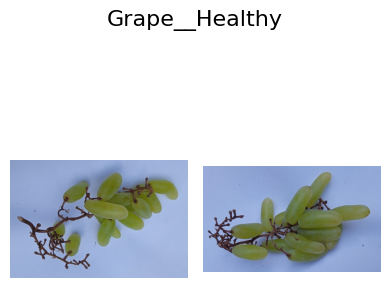

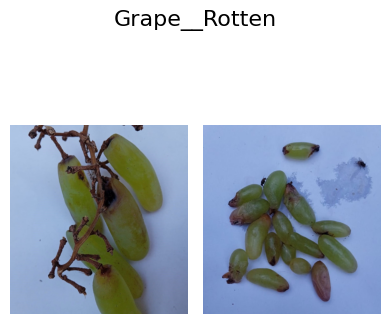

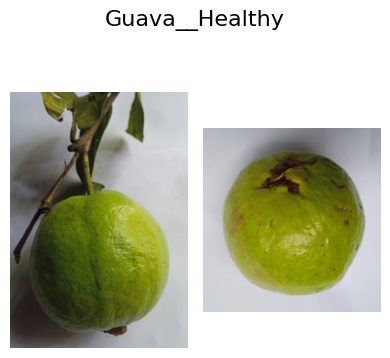

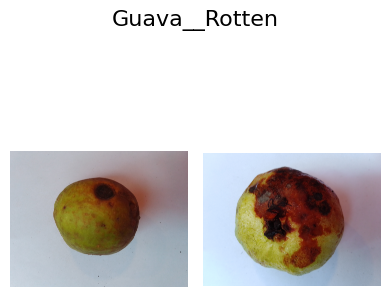

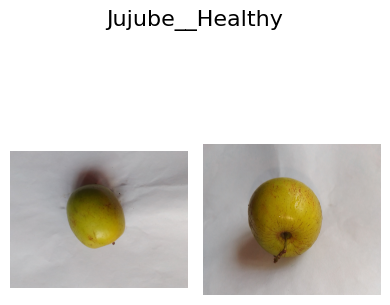

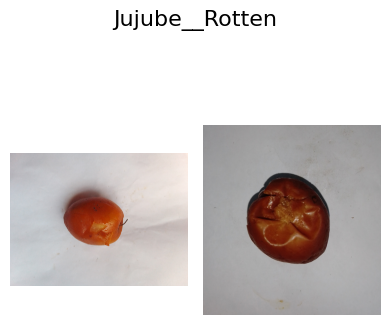

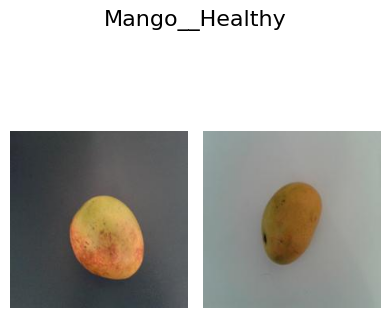

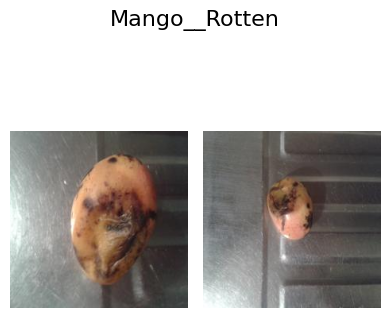

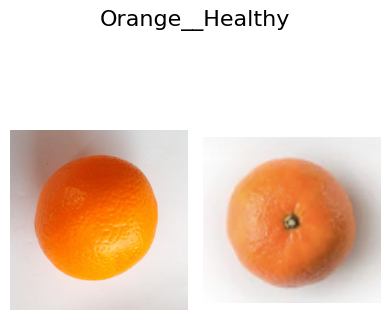

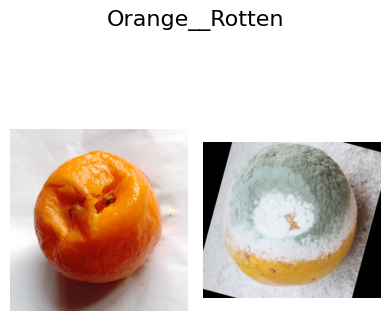

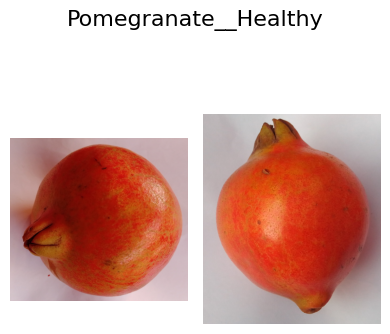

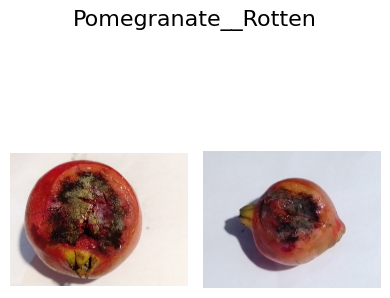

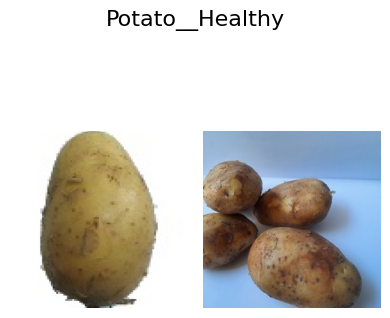

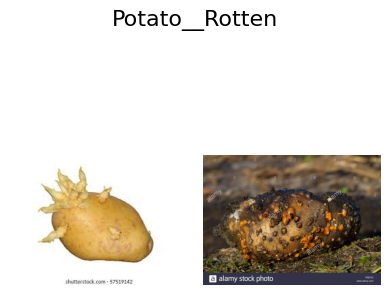

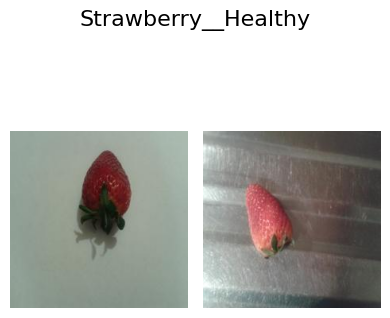

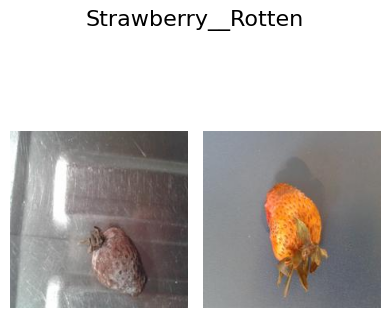

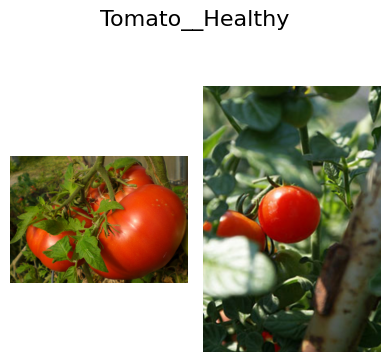

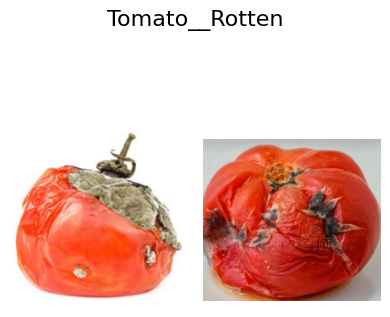

In [15]:
# Plotting 2 random images of each type of rotten and healthy fruits and vegetables
for directory in sub_dirs:
    plot_random_images_from_directory(directory)

# Copying the images

* We will now copy all the images to the training-images directory
* From there, we will move 15 images of each type of fruits and vegetables (both rotten and healthy) to the validation-images and test-images directories

In [16]:
# Getting the list of all subdirectories in that training-images directory
train_sub_dirs = get_sub_dirs(train_dir)
train_sub_dirs[:5]

['/kaggle/working/training-images/Apple__Healthy',
 '/kaggle/working/training-images/Apple__Rotten',
 '/kaggle/working/training-images/Banana__Healthy',
 '/kaggle/working/training-images/Banana__Rotten',
 '/kaggle/working/training-images/Bellpepper__Healthy']

**We will use multi-threading to copy the images faster**

In [17]:
def copy_file(src, dst):
    shutil.copy(src, dst)

def copy_files(source_dirs, dest_dir):
    global train_sub_dirs
    num_files = 0
    tasks = []

    # Create destination directories if they don't exist
    for path in source_dirs:
        dst = os.path.join(dest_dir, os.path.basename(path))
        os.makedirs(dst, exist_ok=True)
        for filename in os.listdir(path):
            num_files += 1
            src = os.path.join(path, filename)
            tasks.append((src, dst))

    # Use ThreadPoolExecutor to copy files
    with ThreadPoolExecutor() as executor:
        executor.map(lambda task: copy_file(*task), tasks)

    count = 0
    for i in range(len(train_sub_dirs)):
        source_num = len(os.listdir(source_dirs[i]))
        dest_num = len(os.listdir(train_sub_dirs[i]))
        if source_num != dest_num:
            count += 1
            print(f"{source_num - dest_num} files were not copied to {train_sub_dirs[i]}")

    if count == 0:
        print(f"All {num_files} files are copied to the training directory.")

# Example usage
if __name__ == "__main__":
    copy_files(sub_dirs, train_dir)

All 29291 files are copied to the training directory.


# Image Preprocessing

* Let's create a function that will return a dictionary with keys as the image filetype, and values as the number of images with that filetype

In [18]:
def get_img_extensions_dict(dir_paths):
    img_extension_dict = {}
    for path in dir_paths:
        for filename in os.listdir(path):
            _, file_extension = os.path.splitext(filename)
            if file_extension not in img_extension_dict:
                img_extension_dict[file_extension] = 1
            else:
                img_extension_dict[file_extension] += 1
    return img_extension_dict

In [19]:
print(get_img_extensions_dict(train_sub_dirs))

{'.png': 11813, '.jpg': 17337, '.webp': 14, '.jpeg': 80, '.JPG': 47}


* We can see that we have images with different filetypes.
* This means that the images might also have different numbers of color channels as well.
* So, let's create a function that will iterate through our training directory and will return a dictionary where the keys will be the color chanels, and the values will be the total number of images with that color channel.

In [20]:
def count_color_channels(folder_paths):
    channel_counts = {}
    mode_to_channels = {'L': 1, 'LA': 2, 'P': 1, 'RGB': 3, 'RGBA': 4, 'CMYK': 4, 'YCbCr': 3, 'HSV': 3, 'LAB': 3, 'I': 1, 'F': 1}
    for folder_path in folder_paths:
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    mode = img.mode
                    channels = mode_to_channels.get(mode)
                    if channels is not None:
                        if channels in channel_counts:
                            channel_counts[channels] += 1
                        else:
                            channel_counts[channels] = 1
                    else:
                        print(f"Unrecognized mode {mode} for file {file_path}")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    
    return channel_counts

In [21]:
color_channel_counts = count_color_channels(train_sub_dirs)
print(color_channel_counts)

{3: 28118, 4: 1168, 1: 5}


* Since we have images with different number of color channels, this will create a problem later while batching and modelling.
* So, let's create a function that will iterate overe all the images in the training directory and convert the images to have the JPEG filetype and RGB as the color channel.
* **NOTE:** We will use multiprocessing to speed up this task.

In [22]:
def convert_images_to_rgb_and_jpeg(directory):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.webp', '.jpeg', '.JPG')):
            file_path = os.path.join(directory, filename)
            new_file_path = os.path.join(directory, os.path.splitext(filename)[0] + '.jpg')

            with Image.open(file_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(new_file_path, 'JPEG')

            # Remove the original file if it's not already a JPEG
            if not filename.lower().endswith('.jpg'):
                os.remove(file_path)


def process_folder(folder_path):
    convert_images_to_rgb_and_jpeg(folder_path)
    print(f'Processed folder: {folder_path}')

with ProcessPoolExecutor() as executor:
    executor.map(process_folder, train_sub_dirs)

print('All the images were converted to JPEG format and to have the RGB color channel.')

Processed folder: /kaggle/working/training-images/Banana__Healthy
Processed folder: /kaggle/working/training-images/Bellpepper__Healthy
Processed folder: /kaggle/working/training-images/Bellpepper__Rotten
Processed folder: /kaggle/working/training-images/Carrot__Healthy
Processed folder: /kaggle/working/training-images/Carrot__Rotten
Processed folder: /kaggle/working/training-images/Apple__Healthy
Processed folder: /kaggle/working/training-images/Banana__Rotten
Processed folder: /kaggle/working/training-images/Cucumber__Healthy
Processed folder: /kaggle/working/training-images/Apple__Rotten
Processed folder: /kaggle/working/training-images/Cucumber__Rotten
Processed folder: /kaggle/working/training-images/Grape__Healthy
Processed folder: /kaggle/working/training-images/Grape__Rotten
Processed folder: /kaggle/working/training-images/Guava__Healthy
Processed folder: /kaggle/working/training-images/Mango__Healthy
Processed folder: /kaggle/working/training-images/Mango__Rotten
Processed fo

### Moving 15 images from each category of fruits and vegetables to the validation and test directories

In [23]:
for root, _, _ in os.walk('/kaggle/working/training-images'):
    if root.split('/')[-1] != 'training-images':
        for i in range(15):
            src_path_test = os.path.join(root, random.choice(os.listdir(root)))
            dst_path_test = '/kaggle/working/test-images/' + root.split('/')[-1]
            shutil.move(src_path_test, dst_path_test)
            src_path_valid = os.path.join(root, random.choice(os.listdir(root)))
            dst_path_valid = '/kaggle/working/validation-images/' + root.split('/')[-1]
            shutil.move(src_path_valid, dst_path_valid)

print("15 images of each types of rotten and healthy fruits and vegetables were moved to the validation and test directories.")

15 images of each types of rotten and healthy fruits and vegetables were moved to the validation and test directories.


# Building tensorflow datasets

In [24]:
def build_img_dataset(directory, BATCH_SIZE=32, SEED=101, IMG_SIZE=(224, 224), class_names=False, shuffle=True):
    dataset = keras.preprocessing.image_dataset_from_directory(
        directory=directory,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        image_size=IMG_SIZE,
        interpolation='bilinear',
        shuffle=shuffle,
        seed=SEED
    )
    
    class_names = dataset.class_names
    
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    
    return (dataset, class_names if class_names else None)

In [25]:
train_data = build_img_dataset(train_dir)[0]
valid_data = build_img_dataset(valid_dir)[0]
test_data, test_classes = build_img_dataset(test_dir, BATCH_SIZE=16, class_names=True) # will need test_classes in visualizing predictions

Found 27398 files belonging to 28 classes.
Found 420 files belonging to 28 classes.
Found 420 files belonging to 28 classes.


# Image augmentation

Data augmentation is a technique to make your model robust to changes in input data such as lighting, cropping, and orientation. One caveat to be aware of with image data augmentation is that you must be careful to not shift your augmented data distribution too far from the original data distribution. The goal is to prevent overfitting and increase generalization, but samples that lie completely out of the data distribution simply add noise to the training process.


[[source]](https://keras.io/guides/keras_cv/classification_with_keras_cv/)

In [26]:
def pack_to_dict(image, label):
    return {"images": image, "labels": label}

train_data = train_data.map(pack_to_dict, num_parallel_calls=tf.data.AUTOTUNE)

In [27]:
batch = next(iter(train_data.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

def visualize_images(rows=2, cols=2, augmentation=None, images=image_batch):
    keras_cv.visualization.plot_image_gallery(
        augmentation(image_batch) if augmentation else image_batch,
        rows=rows,
        cols=cols,
        value_range=(0, 255),
        show=True,
    )

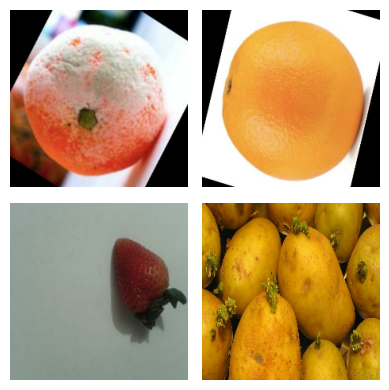

In [28]:
# Let's visualize some images before applying augmentation
visualize_images()

### RandomFlip augmentation

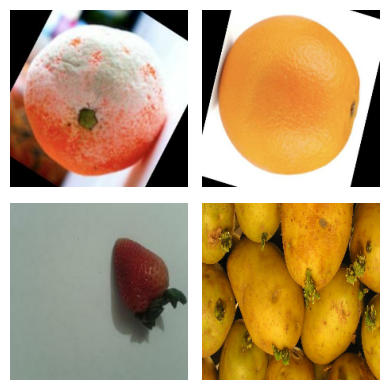

In [29]:
random_flip = keras_cv.layers.RandomFlip(
    mode="horizontal_and_vertical"
)
visualize_images(augmentation = random_flip)

### RandomCropAndResize Augmentation

The next augmentation we'll use is RandomCropAndResize. This operation selects a random subset of the image, then resizes it to the provided target size. By using this augmentation, we force our classifier to become spatially invariant. Additionally, this layer accepts an ```aspect_ratio_factor``` which can be used to distort the aspect ratio of the image. While this can improve model performance, it should be used with caution. It is very easy for an aspect ratio distortion to shift a sample too far from the original training set's data distribution. 


[[source]](https://keras.io/guides/keras_cv/classification_with_keras_cv/)

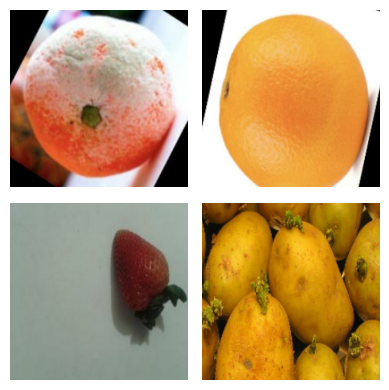

In [30]:
random_crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size = (224, 224),
    crop_area_factor = (0.8, 1.0),
    aspect_ratio_factor = (0.9, 1.1),
)

visualize_images(augmentation = random_crop_and_resize)

### RandomShear Augmentation

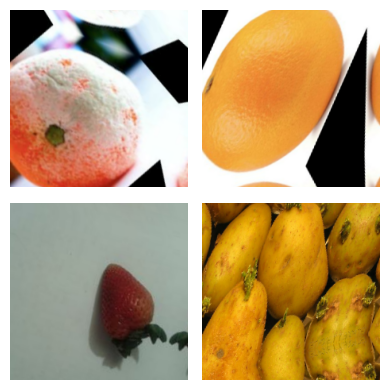

In [31]:
random_shear = keras_cv.layers.RandomShear(
    x_factor = (0.2, 0.4),
    y_factor = (0.2, 0.4),
    interpolation = "bilinear",
    fill_mode = "reflect",
)

visualize_images(augmentation = random_shear)

### RandomHue Augmentation

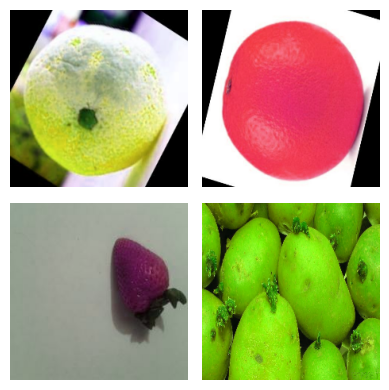

In [32]:
random_hue = keras_cv.layers.RandomHue(
    factor = (0.2, 0.3),
    value_range = [0, 255]
)

visualize_images(augmentation = random_hue)

### Building and applying the image augmentation pipeline

In [33]:
aug_pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=[random_flip, random_crop_and_resize, random_hue, random_shear],
    augmentations_per_image=4,
)

train_data = train_data.map(aug_pipeline, num_parallel_calls=tf.data.AUTOTUNE)

### Visualizing some images after applying the augmentation pipeline

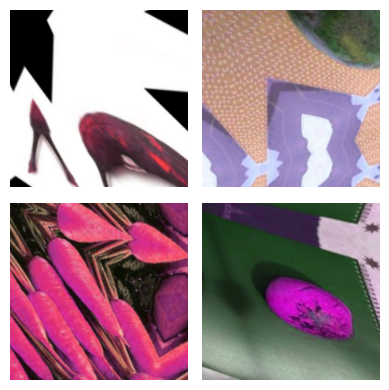

In [34]:
image_batch = next(iter(train_data.take(1)))['images']
visualize_images(images = image_batch)

In [35]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

train_data = train_data.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

# Modelling

In [36]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True
)

inputs = tf.keras.layers.Input(shape=(None, None, 3))
resized_inputs = tf.keras.layers.Resizing(224, 224)(inputs)
x = base_model(resized_inputs)
outputs = tf.keras.layers.Dense(len(test_classes), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,955,180 (22.72 MB)

 Trainable params: 5,894,572 (22.49 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [37]:
# Creating an earlystopping callback
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=2,
    verbose=1,
    mode='min',
    restore_best_weights=True,
)

In [38]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=2,
                    verbose=1,
                    callbacks=[earlystopping])

Epoch 1/2
857/857 ━━━━━━━━━━━━━━━━━━━━ 420s 452ms/step - accuracy: 0.6219 - loss: 1.4762 - val_accuracy: 0.9214 - val_loss: 0.2429
Epoch 2/2
857/857 ━━━━━━━━━━━━━━━━━━━━ 284s 311ms/step - accuracy: 0.9172 - loss: 0.2693 - val_accuracy: 0.9619 - val_loss: 0.1240
Restoring model weights from the end of the best epoch: 2.


# Plotting the model accuracy and model loss

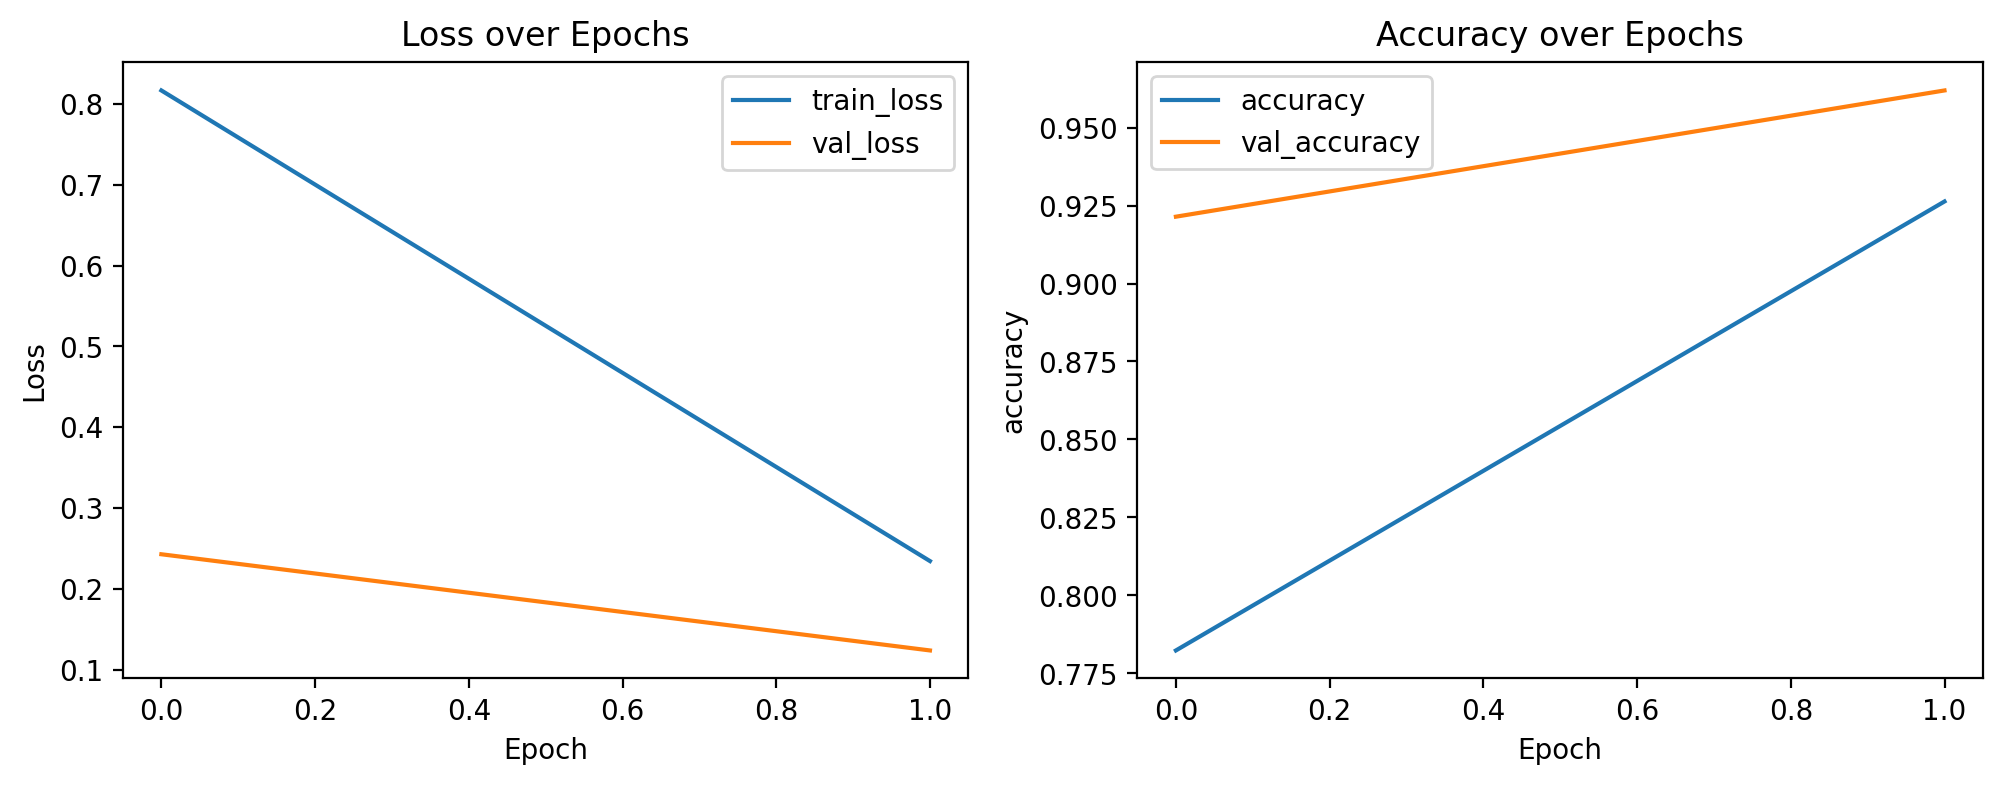

In [39]:
plt.figure(figsize=(12, 4), dpi=200)
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show();

# Model evaluation

In [40]:
K.clear_session()

In [41]:
loss, accuracy = model.evaluate(test_data)
print(f"The model loss on the test dataset is {round(loss, 4)}.")
print(f"The model accuracy on the test dataset is {round(accuracy, 2)*100}%.")

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9656 - loss: 0.1018
The model loss on the test dataset is 0.1366.
The model accuracy on the test dataset is 96.0%.


* We will now plot 9 random images from the test dataset along with their true and predcited labels
* If the predicted label matches the original label, the labels will be coloured in green, else, the labels will be coloured in red

In [42]:
def display_images_with_predictions_and_true_labels(dataset, model, test_classes, num_images=9):
    plt.figure(figsize=(10, 10))

    # Take a batch from the dataset and select random images
    for images, labels in dataset.take(1):
        indices = np.random.choice(images.shape[0], num_images, replace=False)
        random_images = images.numpy()[indices]
        true_labels = labels.numpy()[indices]
        
        # Convert true labels to integer indices if they are one-hot encoded
        if len(true_labels.shape) > 1:
            true_labels = np.argmax(true_labels, axis=1)

        predictions = model.predict(random_images)
        predicted_labels = np.argmax(predictions, axis=1)

        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(random_images[i].astype("uint8"))
            if true_labels[i] == predicted_labels[i]:
                color = 'green'
            else:
                color = 'red'
            plt.title(f"True: {test_classes[true_labels[i]]}\nPredicted: {test_classes[predicted_labels[i]]}",
                      color=color)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


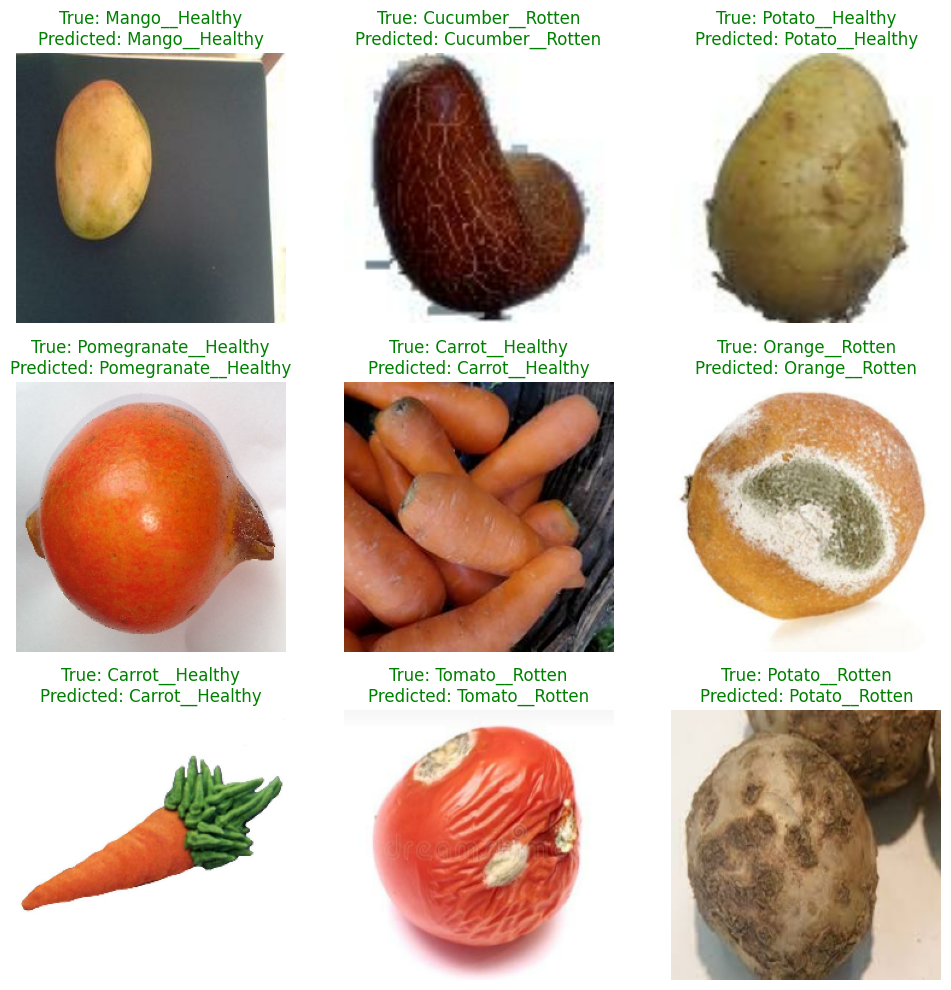

In [43]:
display_images_with_predictions_and_true_labels(test_data, model, test_classes)